## Factor Model Challenge
### File Description
#### Name: Saagar Shah
#### Models Used: Mean Variance Optimization

----

### Import Packages

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Saagar_Shah_portfolio_analysis import PortfolioAnalysis
import cvxpy as cp
import random

/Users/saagar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


----

### Get Data / Data Preprocess

In [2]:
portfolio = PortfolioAnalysis("Dummy_Data.xlsx")
stocks = list(portfolio.asset_values["Stock"])
stocks.remove("NAV")
stocks.remove("Cash")
training_start_date = "2023-01-01"
training_end_date = "2023-07-01"
data = yf.download(stocks, end = "2023-07-01")["Adj Close"].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  11 of 11 completed


----

### Exploratory Data Analysis (EDA)

In [3]:
cov_matrix = data.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix)

### Modeling

##### Model 1:
Description:  Using Covariance Matrix

# Using the mean variance optimization model, using the covariance matrix, assuming no shorting in the portfolio so only using the positive weights and standardizing them between 0 and 1. These weights are then factored in to finding the return

In [4]:
ones = np.ones(len(stocks))
minVar = (np.dot(inv_cov_matrix, ones))/(np.dot(np.dot(ones.T, inv_cov_matrix), ones))
posIndexes = []
for i in range(len(minVar)):
    if minVar[i] > 0:
        posIndexes.append(i)
sumWeights = sum(minVar[posIndexes])
standardized_weights = []
for i in minVar[posIndexes]:
    standardized_weights.append(i/sumWeights)

##### Model 2:
Description:  

----

### Backtest

In [5]:
def trade(ticker: str, start_date: str, end_date: str, allocated_amount: float, weight: float):
    # Download the adjusted closing prices
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Calculate the number of shares that can be purchased at the start date
    initial_price = df['Adj Close'].iloc[0]
    shares = allocated_amount / initial_price
    
    # Calculate the portfolio value over time, considering stock splits
    df['Shares'] = shares
    df['Portfolio Value'] = df['Shares'] * df['Adj Close']
    df['Return'] = df['Portfolio Value'].diff()
    df['Cumulative Return'] = df['Return'].cumsum()
    
    return df[['Return', 'Cumulative Return']]

def trade_portfolio(stocks: list, amount: float, start_date: str, end_date: str, weights: list): #Runs the trade on all stocks in the portfolio
    cumulative_returns = None

    for i in range(len(stocks)):
        cur_trade = trade(stocks[i], start_date, end_date, amount * weights[i], weights[i])
        if cumulative_returns is None:
            cumulative_returns = cur_trade
        else:
            cumulative_returns['Return'] += cur_trade['Return']
            cumulative_returns['Cumulative Return'] += cur_trade['Cumulative Return']

    return cumulative_returns['Return'].dropna(), cumulative_returns['Cumulative Return'].dropna()

def volatility(stocks: list, amount: float, start_date: str, end_date: str, weights: list): #Returns volatility (standard deviation)
    volatility = np.std(trade_portfolio(stocks, amount, start_date, end_date, weights)[0])
    return volatility

def sharpe_Ratio(stocks: list, amount: float, start_date: str, end_date: str, weights: list): #Returns sharpe ratio
    risk_free_rate = yf.download('^IRX')["Adj Close"][-1]/100
    trade_returns = trade_portfolio(stocks, amount, start_date, end_date, weights)[1]
    port_return = trade_returns.iloc[0]  # Last return value
    port_volatility = volatility(stocks, amount, start_date, end_date, weights)
    sharpe = (port_return - risk_free_rate) / port_volatility
    return sharpe

marketReturns = trade("SPY", "2023-07-01", "2023-09-30", 200, 1)["Return"] #Saves market returns
weightedReturns = trade_portfolio(data.columns[posIndexes], 200, "2023-07-01", "2023-09-30", standardized_weights)[0] #Saves weighted portfolio returns
cumMarketReturns = trade("SPY", "2023-07-01", "2023-09-30", 200, 1)["Cumulative Return"] #Saves cumulative returns
cumWeightedReturns = weightedReturns = trade_portfolio(data.columns[posIndexes], 200, "2023-07-01", "2023-09-30", standardized_weights)[1] #Saves cumulated weighted portfolio returns
sharpeWeights = sharpe_Ratio(data.columns[posIndexes], 200, "2023-07-01", "2023-09-30", standardized_weights) #Saves the weighted portfolio sharpe ratio
sharpeMarket = sharpe_Ratio(["SPY"], 200, "2023-07-01", "2023-09-30", [1]) #Saves the mnarket sharpe ratio
volatilityWeights = volatility(data.columns[posIndexes], 200, "2023-07-01", "2023-09-30", standardized_weights) #Saves the weighted portfolio volatility
volatilityMarket = volatility(["SPY"], 200, "2023-07-01", "2023-09-30", [1]) #Saves the weighted portfolio volatility

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
print("Sharpe Market:" + str(sharpeMarket))
print("Sharpe Weighted Portfolio: " + str(sharpeWeights))
print("Volatility Market: " + str(volatilityMarket))
print("Volatility Weighted Portfolio: " + str(volatilityWeights))
print("Weighted portfolio returned a similar return with less variance")

Sharpe Market:-0.25757140112440324
Sharpe Weighted Portfolio: -0.3687838140985317
Volatility Market: 1.3609425200760386
Volatility Weighted Portfolio: 1.1914744845441152
Weighted portfolio returned a similar return with less variance


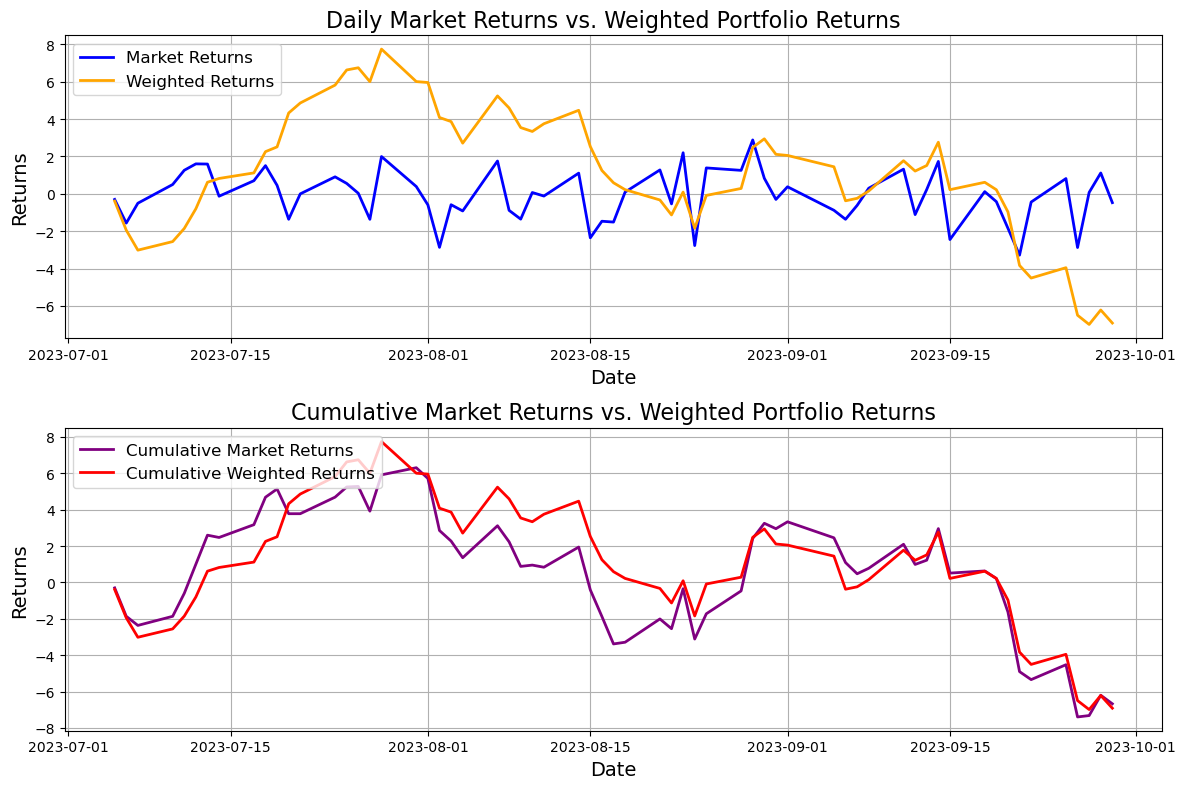

In [7]:
plt.figure(figsize=(12, 8))
subplot1 = plt.subplot(2, 1, 1)
subplot2 = plt.subplot(2, 1, 2, sharex=subplot1)
subplot1.plot(marketReturns.index, marketReturns, label='Market Returns', color='blue', linewidth=2)
subplot1.plot(weightedReturns.index, weightedReturns, label='Weighted Returns', color='orange', linewidth=2)
subplot2.plot(cumMarketReturns.index, cumMarketReturns, label='Cumulative Market Returns', color='purple', linewidth=2)
subplot2.plot(cumWeightedReturns.index, cumWeightedReturns, label='Cumulative Weighted Returns', color='red', linewidth=2)
subplot1.set_xlabel('Date', fontsize=14)
subplot1.set_ylabel('Returns', fontsize=14)
subplot1.set_title('Daily Market Returns vs. Weighted Portfolio Returns', fontsize=16)
subplot2.set_xlabel('Date', fontsize=14)
subplot2.set_ylabel('Returns', fontsize=14)
subplot2.set_title('Cumulative Market Returns vs. Weighted Portfolio Returns', fontsize=16)
subplot1.legend(fontsize=12, loc='upper left')
subplot2.legend(fontsize=12, loc='upper left')
subplot1.grid(True)
subplot2.grid(True)
plt.tight_layout()
plt.show()

----

Additional Comments:

I approached the task thinking about ways to allocate the portfolio. I created a mean portfolio optimization 
program in the past and thought how I could apply that here. The program in the past had allocations for shorting a stock, and so in order to make it applicable to SSMIF, I decided to only use the stocks with positive allocations and standardize the allocations to be between 0 and 1, and to add up to 1.